# Unicode Distribution Creation
The purpose of this project is to demonstrate how a set of unicode characters can be turned into a probability distribution for sampling from. The goal is to create a ipython magic function so this can be done easily. For example the following code would create a close to normal distribution object:
```
%%ascii_dist
   _____
  /     \
 /       \
/         \
```

Some example usage demonstrations follow.

In [1]:
# import the library
%run ascii_dist.py

In [2]:
%%ascii_dist
\
 \
  \_
    \_/\/\

In [3]:
# draw samples from the distribution created
dist.sample(10)

array([0.34397163, 0.16666667, 0.64539007, 0.35815603, 0.70212766,
       0.21276596, 0.64539007, 0.24113475, 0.72340426, 0.09929078])

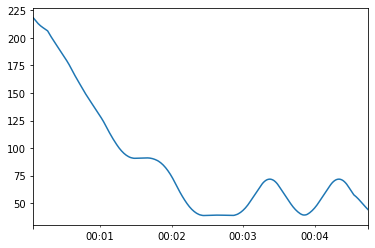

In [4]:
# show the image the distribution was based on
dist.image()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba969ba5c0>]],
      dtype=object)

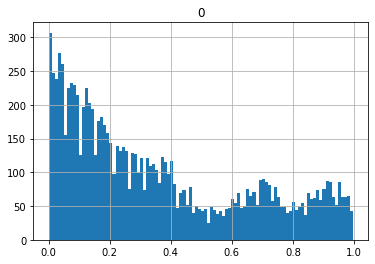

In [5]:
# visualize the distribution through repeated sampling
dist.plot(10000)